In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler, Normalizer
import scipy.sparse

from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin
import joblib
import warnings
warnings.filterwarnings("ignore")
import string
sns.set_style("dark")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test.txt to test.txt
Saving train.txt to train.txt
Saving val.txt to val.txt


In [ ]:
train_data = pd.read_csv(
    "train.txt",
    sep=";",
    header=None,
    names=["text", "emotion"],
)
test_data = pd.read_csv(
    "test.txt",
    sep=";",
    header=None,
    names=["text", "emotion"],
)
validation_data = pd.read_csv(
    "val.txt",
    sep=";",
    header=None,
    names=["text", "emotion"],
)

data = {
    "train": [],
    "accuracy": [],
}

train_models = pd.DataFrame(data, columns=["train", "accuracy"])
data = {
    "test": [],
    "accuracy": [],
}

test_models = pd.DataFrame(data, columns=["test", "accuracy"])

data = {
    "validation": [],
    "accuracy": [],
}

validation_models = pd.DataFrame(data, columns=["validation", "accuracy"])

In [ ]:
print("Train Data\n ", train_data.head(5))
print("---------------------------------------------------------------------------------")

print("Test Data\n", test_data.head(5))
print("---------------------------------------------------------------------------------")

print("Validation Data\n", validation_data.head(5))

Test Data
                                                  text  emotion
0  im feeling rather rotten so im not very ambiti...  sadness
1          im updating my blog because i feel shitty  sadness
2  i never make her separate from me because i do...  sadness
3  i left with my bouquet of red and yellow tulip...      joy
4    i was feeling a little vain when i did this one  sadness
---------------------------------------------------------------------------------
Train Data
                                                 text  emotion
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger
---------------------------------------------------------------------------------
Validation Data
                                                 tex

In [ ]:
class text_processing(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        lower=False,
        upper=False,
        remove_special_characters=False,
        remove_punctuation=False,
        remove_stop_words=False,
        stem_the_words=False,
    ) -> None:
        self.lower = lower
        self.upper = upper
        self.remove_special_characters = remove_special_characters
        self.remove_punctuation = remove_punctuation
        self.remove_stop_words = remove_stop_words
        self.stem_the_words = stem_the_words
        super().__init__()

    def fit(self, X, y=None):
        return self

    # for converting the text to lower case
    def __convert_text_lower(self, text):
        text = text.lower()
        return text

    def __lower_text(self, X):
        X = X.apply(self.__convert_text_lower)
        return X

    # for converting the text to upper case
    def __convert_text_upper(self, text):
        text = text.upper()
        return text

    def __upper_text(self, X):
        X = X.apply(self.__convert_text_upper)
        return X

    # for converting the text to words
    def __TextToWord(self, X):
        words = word_tokenize(X)
        return words

    # for removing Special Characters
    def __remove_spec(self, X):
        words = self.__TextToWord(X)
        fixed_words = []
        for w in words:
            if w.isalnum():
                fixed_words.append(w)
        return " ".join(fixed_words)

    def __Remove_Special_Characters(self, X):
        X = X.apply(self.__remove_spec)
        return X

    # for removing Punctuation
    def __remove_puncs(self, X):
        words = self.__TextToWord(X)
        punctuation = set(string.punctuation)
        fixed_words = []
        for w in words:
            if not punctuation.__contains__(w):
                fixed_words.append(w)
        return " ".join(fixed_words)

    def __Remove_Punctuation(self, X):
        X = X.apply(self.__remove_puncs)
        return X

    # for removing Stop Words
    def __remove_stop(self, X):
        stop_words = set(stopwords.words("english"))
        words = self.__TextToWord(X)
        fixed_words = []
        for w in words:
            if not stop_words.__contains__(w):
                fixed_words.append(w)
        return " ".join(fixed_words)

    def __Remove_stop_words(self, X):
        X = X.apply(self.__remove_stop)
        return X

    # for Stemming the words
    def __stem_text(self, text):
        stemmer = PorterStemmer()
        words = self.__TextToWord(text)
        stemmed_words = []
        for w in words:
            stemmed_words.append(stemmer.stem(w))
        return " ".join(stemmed_words)

    def __Stemming(self, X):
        X = X.apply(self.__stem_text)
        return X

    # we will apply the text processing based on the parameters
    def process_text(self, X):
        data = X.copy()
        # will lowercase the text
        if self.lower:
            data = self.__lower_text(data)
        # will uppercase the text
        if self.upper:
            data = self.__upper_text(data)
        # will remove the special characters
        if self.remove_special_characters:
            data = self.__Remove_Special_Characters(data)
        # will remove the punctuation
        if self.remove_punctuation:
            data = self.__Remove_Punctuation(data)
        # will remove the stop words
        if self.remove_stop_words:
            data = self.__Remove_stop_words(data)
        # will stem the words
        if self.stem_the_words:
            data = self.__Stemming(data)
        return data

    def transform(self, X, y=None):
        if isinstance(X, (scipy.sparse.csr_matrix, scipy.sparse.csc_matrix)):
            # Convert sparse matrix to dense array for text processing
            X = pd.Series(X.toarray().ravel())  # Convert to Series for apply
            # **CHANGE:** Convert elements to strings before processing
            X = X.astype(str) # convert all to strings to apply .lower()
            X = self.process_text(X)
            # Convert back to sparse matrix if needed
            X = scipy.sparse.csr_matrix(X.values.reshape(1, -1)) # reshape to (1, num_features)
        else:
            X = self.process_text(X)
        return X

In [ ]:
# removing Duplicate data
combine = [train_data, test_data, validation_data]
for data_set in combine:
    print(data_set.duplicated().sum()) #identifying duplicates
print( "---------------------------------------------------------------------------------")
for data_set in combine:
    data_set.drop_duplicates(inplace=True)#dropping duplicates
    print(data_set.duplicated().sum())

0
0
0
---------------------------------------------------------------------------------
0
0
0


In [ ]:
train_x_train = train_data.text
train_y_train = train_data.emotion

test_x_test = test_data.text
test_y_test = test_data.emotion

validation_x_val = validation_data.text
validation_y_val = validation_data.emotion

In [ ]:
label_encoder = LabelEncoder()
train_y_train = label_encoder.fit_transform(train_y_train)
test_y_test = label_encoder.transform(test_y_test)
validation_y_val = label_encoder.transform(validation_y_val)

In [ ]:
label_encoder.classes_

array(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'],
      dtype=object)

In [ ]:
def acc_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


def conf_mat(model,train_x_train_processed, test_x_test_processed, validation_x_val_processed):
    pipeline_train_pred = model.predict(train_x_train_processed)
    pipeline_test_pred = model.predict(test_x_test_processed)
    pipeline_val_pred = model.predict(validation_x_val_processed)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    cm = confusion_matrix(list(train_y_train), list(pipeline_train_pred))
    sns.heatmap(
        cm,
        annot=True,
        ax=ax[0],
        fmt="d",
        cmap="Greens",
    )
    ax[0].set_title("Train Data")
    ax[0].set_xlabel("Predicted Labels")
    ax[0].set_ylabel("True Labels")

    cm = confusion_matrix(list(test_y_test), list(pipeline_test_pred))
    sns.heatmap(
        cm,
        annot=True,
        ax=ax[1],
        fmt="d",
        cmap="Greens",
    )
    ax[1].set_title("Test Data")
    ax[1].set_xlabel("Predicted Labels")
    ax[1].set_ylabel("True Labels")

    cm = confusion_matrix(list(validation_y_val), list(pipeline_val_pred))
    sns.heatmap(
        cm,
        annot=True,
        ax=ax[2],
        fmt="d",
        cmap="Greens",
    )
    ax[2].set_title("Validation Data")
    ax[2].set_xlabel("Predicted Labels")
    ax[2].set_ylabel("True Labels")
    plt.legend()
    plt.show()

In [ ]:
# SVM
"""
        Steps of model
        1. Text Processing
        2. Vectorization by using CountVectorizer for converting the text to numbers
        3. scaling the data by using StandardScaler
        3. Training the model by using Pipeline
"""

text_processing_odj = text_processing(
    lower=True,
    remove_special_characters=True,
    remove_punctuation=True,
    remove_stop_words=True,
    stem_the_words=False,
)
count = CountVectorizer(max_features=3000)
svm = SVC(kernel="linear",gamma=1, C=.5, random_state=42)
svm_pipeline = Pipeline(
    [
        ("text_processing", text_processing_odj),
        ("vectorizer", count),
        ("svm", svm),
    ]
)
svm_pipeline.fit(train_x_train, train_y_train)
joblib.dump(svm_pipeline, 'svm_model.pkl')  # Save the model
joblib.dump(count, 'vectorizer.pkl')

['vectorizer.pkl']

In [ ]:
process_pip = Pipeline(
    [
        ("text_processing", text_processing_odj),
    ]
)
train_x_train_processed = process_pip.fit_transform(train_x_train)
test_x_test_processed = process_pip.transform(test_x_test)
validation_x_val_processed = process_pip.transform(validation_x_val)


In [ ]:
# validation by using the accuracy score, confusion matrix, and classification report

print("Train: ",acc_score(train_y_train, svm_pipeline.predict(train_x_train_processed)))
print("Test: ",acc_score(test_y_test, svm_pipeline.predict(test_x_test_processed)))
print("Validation: ",acc_score(validation_y_val, svm_pipeline.predict(validation_x_val_processed)))

train_models.loc[len(train_models)] = ["SVM", acc_score(train_y_train, svm_pipeline.predict(train_x_train_processed))]
test_models.loc[len(test_models)] = ["SVM", acc_score(test_y_test, svm_pipeline.predict(test_x_test_processed))]
validation_models.loc[len(validation_models)] = ["SVM", acc_score(validation_y_val, svm_pipeline.predict(validation_x_val_processed))]

Train:  0.9680605037814863
Test:  0.8825
Validation:  0.8915


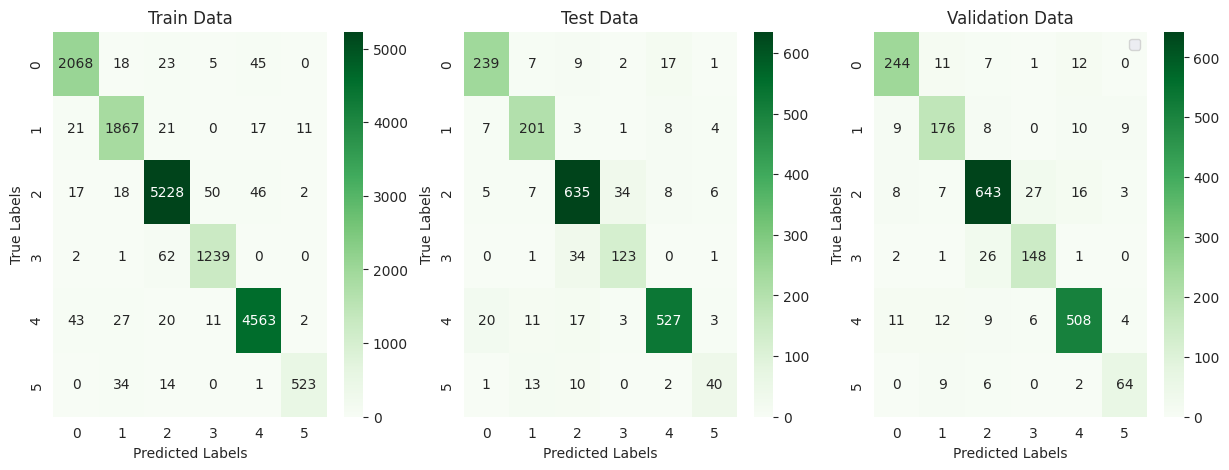

In [ ]:
conf_mat(
    svm_pipeline, train_x_train_processed, test_x_test_processed, validation_x_val_processed
)

In [ ]:
svm_pipeline = joblib.load('svm_model.pkl')
count_vectorizer = joblib.load('vectorizer.pkl')

# Function to predict the emotion of user input
def predict_emotion(text):
    # Preprocess the input text (using the same pipeline as during training)
    processed_text = svm_pipeline.named_steps['text_processing'].transform(pd.Series([text]))
    # Vectorize using the loaded vectorizer
    vectorized_text = count_vectorizer.transform(processed_text)
    # Predict using the loaded model
    predicted_emotion_encoded = svm_pipeline.named_steps['svm'].predict(vectorized_text)

    # Define emotion labels
    emotion_labels = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

    # Inverse transform to get the emotion label
    predicted_emotion = emotion_labels[predicted_emotion_encoded[0]]

    return predicted_emotion


# Get user input
user_input = input("Enter a text: ")

# Predict the emotion
predicted_emotion = predict_emotion(user_input)

print("Predicted emotion:", predicted_emotion)


Enter a text: I am scared
Predicted emotion: fear
